In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
local_llm = 'llama3'

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import FireCrawlLoader
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.docstore.document import Document

/opt/anaconda3/envs/nlp-fall/lib/python3.12/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [5]:
urls = [
    'https://omeka.org/s/docs/developer/api/',
    'https://omeka.org/s/docs/developer/api/php_api/',
    'https://omeka.org/s/docs/developer/api/rest_api/',
    'https://omeka.org/s/docs/developer/api/representations/',
    'https://omeka.org/s/docs/developer/api/api_reference/',
    'https://omeka.org/s/docs/developer/api/rest_api_reference/'    
]

docs_list = [FireCrawlLoader(api_key=os.getenv('FIRECRAWL_API_KEY'), url=url, mode='scrape').load() for url in urls]
print(docs_list)

[[Document(metadata={'title': 'Introduction to the API - Omeka S Developer Documentation', 'language': 'en', 'ogLocaleAlternate': [], 'sourceURL': 'https://omeka.org/s/docs/developer/api/', 'statusCode': 200}, page_content='\n\n# Introduction to the API [\uf0c1](\\#introduction-to-the-api "Permanent link")\n\nOmeka S provides an application programming interface (API) that enables [CRUD](https://en.wikipedia.org/wiki/Create,_read,_update_and_delete)\noperations on its resources. API resources are objects with a type, associated data,\nrelationships to other resources, and sets of methods that operate on them. There\nare two ways to access Omeka\'s API:\n\n- Programmatically, from within Omeka\'s PHP environment (see the [PHP API documentation](php_api/))\n- Using Omeka\'s [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web service (see the [REST API documentation](rest_api/))\n\n## Operations [\uf0c1](\\#operations "Permanent link")\n\nYou can perform these API op

In [6]:

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=30
)

docs = [doc for sublist in docs_list for doc in sublist]
docs_splits = text_splitter.split_documents(docs)

# Filter out complex metadata and ensure proper document formatting
filtered_docs = []
for doc in docs_splits:
    # Ensure the doc is an instance of Document and has a 'metadata' attribute
    if isinstance(doc, Document) and hasattr(doc, 'metadata'):
        clean_metadata = {k: v for k, v in doc.metadata.items() if isinstance(v, (str, int, float, bool))}
        filtered_docs.append(Document(page_content=doc.page_content, metadata=clean_metadata))

# Add to vectorDB
vectorestore = Chroma.from_documents(
    documents=filtered_docs,
    collection_name="rag-chroma",
    embedding=GPT4AllEmbeddings()
)

retriever = vectorestore.as_retriever(search_kwargs={"k":7}) # number of relavant docs to retrieve

In [7]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format='json', temperature=0) # format : defines the format between user and model

# Llama has specific prompt style as show below
prompt = PromptTemplate(template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
of a retrieved document to a user question. If the document contains keywords related to the user question,
grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

<|eot_id|><|start_header_id|>user<|end_header_id|>
Here is the retrieved document: \n\n {document} \n\n
Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
""",
input_variables=["question", "document"])

retrieval_grader = prompt | llm | JsonOutputParser()


In [8]:
### Test the retreival grader

# Test 1: Something Relevant
relevant_question = "Give me sample PHP Api in Omeka-s?"
docs = retriever.invoke(relevant_question)
relevant_doc_txt = docs[0].page_content  # check against the first doc
print("Relevant question and doc result: ", retrieval_grader.invoke({"question": relevant_question, "document": relevant_doc_txt}))

# Test 2: Something Relevant
irrelevant_question = "How to use nodejs?"
docs = retriever.invoke(relevant_question)
irrelevant_doc_txt = docs[0].page_content  # check against the first doc
print("Irrelevant question and doc result: ", retrieval_grader.invoke({"question": irrelevant_question, "document": irrelevant_doc_txt}))

Relevant question and doc result:  {'score': 'yes'}
Irrelevant question and doc result:  {'score': 'no'}


In [9]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context for more information to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0) # format = 'json' would give result in json

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [19]:
# question = "Give me example usage of resource_class_label api"
question = "Who is the president of Fisk University?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({
    "context": format_docs(docs), "question": question
})
print(generation) # Not a good answer because the FireCrawl's crawl output is not good.

I don't know. The provided context does not mention Fisk University or its president. It appears to be documentation about Omeka S, a web-based platform for curating and sharing digital collections and datasets.


In [11]:
print(format_docs(docs))

Beyond the values, there is other common resource data you might need to access, and each
piece generally has its own method.

- `resourceClass` and `resourceTemplate` get you the Representations for the class and template
for this resource, if any, respectively. To more simply print the resource class's label,
there is a convenience method `displayResourceClassLabel`. It takes an optional default
fallback value, like `displayTitle` and `displayDescription`.
- `owner` gets the Representation for the user that owns the resource, if any.
- `isPublic` returns a boolean marking whether the resource is public.
- `created` and `modified` return PHP DateTime objects for the dates the resource was created
and last modified, respectively. The `$this->i18n()->dateFormat()` helper is useful for
printing and localizing dates.
- `values` simply returns an array of all the values for the resource, grouped by property,
with the properties' Representations and any alternate labels or comments imposed 

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [20]:
### Hallucinatin Grader

llm = ChatOllama(model=local_llm, format='json', temperatur=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate
whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>

Here are the facts:
\n --------- \n
{documents}
\n --------- \n
Here is the answer: {generation} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()

In [21]:
hallucination_grader.invoke(({"documents": docs, "generation": generation}))

{'score': 'no'}

In [22]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an answer is useful to resolve a question. 
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n -------- \n
    {generation}
    \n -------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"])

answer_grader = prompt | llm | JsonOutputParser()

### Agent

In [23]:
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'no'}

In [49]:
from typing_extensions import TypedDict
from typing import List


### State
class GraphState(TypedDict):
    """"
    Represents the state of our graph

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to search in web for documents
        documents: list of documents
    """

    question: str
    generation: str
    web_search: bool
    documents: List[str]


### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("--RETRIEVE--")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question If any document is not relevant, we
    will set a flag to run web search

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("--CHECK DOCUMENT RELEVANCE TO QUESTION--")
    question = state["question"]
    documents = state["documents"]

    # Score each docs
    filtered_docs = []
    web_search = False

    for doc in documents:
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score['score']
        
        # Check document relevant
        if grade.lower() == "yes":
            print("--GRADE: DOCUMENT RELEVANT--")
            filtered_docs.append(doc)
        
        # Document not relevant
        else:
            print("--GRADE: DOCUMENT NOT RELEVANT--")
            # Avoid adding to the filtered docs list
            web_search = True
            continue

    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("--GENERATE--")
    question = state["question"]
    documents = state["documents"]

    # RAG Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
    

def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Appended web results to documents
    """

    print("--WEB SEARCH--")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    
    return {"documents": documents, "question": question}


### Conditional edge

def decide_to_generate(state):
    """
    Determine whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    
    Returns:
        str: Decision for next node
    """

    print("--ACCESS GRADED DOCUMENTS--")
    question = state["question"]
    web_search = state["web_search"]
    filtered_docs = state["documents"]

    if web_search:
        # All documents have been filtered check_relance
        # we will re-generate a new query

        print("--DECISION: ALL DECISIONS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH --")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("--DECISION: GENERATE--")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Checks for the hallucination in the LLM generation
     Args:
        state (dict): The current graph state
    
    Returns:
        str: Result of hallucination for the LLM generation
    """

    print("--CHECK HALLUCINATIONS--")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score["score"]

    # Check hallucination
    if grade.lower() == "yes":
        print("--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--")

        # Check question-answering
        print("--GRADE GENERATION vs QUESTION--")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade.lower() == "yes":
            print("--DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("--DECISION: GENERATION DOES NOT ADDRESS QUESTION--")
            return "not useful"
    else:
        print("--DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY--")
        return "not supported"
        

In [50]:
from langgraph.graph import START, END, StateGraph
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

In [51]:
# Build the graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch"
    },
)

custom_graph = workflow.compile()

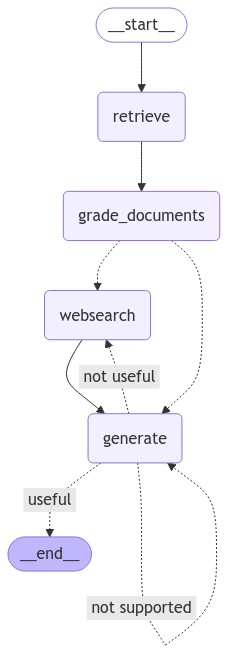

In [52]:
from IPython.display import Image, display

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [53]:
# Test

from pprint import pprint
inputs = {"question": "Who is the president of fisk university?"}

for output in custom_graph.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
print(value["generation"])

--RETRIEVE--
'Finished running: retrieve:'
--CHECK DOCUMENT RELEVANCE TO QUESTION--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT--
--ACCESS GRADED DOCUMENTS--
--DECISION: ALL DECISIONS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH --
'Finished running: grade_documents:'
--WEB SEARCH--
'Finished running: websearch:'
--GENERATE--
--CHECK HALLUCINATIONS--
--DECISION: GENERATION IS GROUNDED IN DOCUMENTS--
--GRADE GENERATION vs QUESTION--
--DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
The current president of Fisk University is Dr. Agenia Walker Clark, according to the provided context. However, it's noted that Dr. Vann Newkirk Sr. was previously the president from February 5th onwards.
